# Library

In [56]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns 
import datetime

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import Imputer, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [58]:
#Loading data
%ls
train = pd.read_csv('./data/train_u6lujuX_CVtuZ9i.csv')
test = pd.read_csv('./data/test_Y3wMUE5_7gLdaTN.csv')
train.set_index('Loan_ID',inplace=True)
test.set_index('Loan_ID',inplace=True)

data/  notebook.ipynb  submission/


In [59]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (614, 12)
Test shape: (367, 11)


# EDA

In [60]:
train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [61]:
test.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
Loan_ID,,,,,,,,,,,
LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


## Missing values

In [62]:
print(train.isnull().sum())
# number of samples with at least 1 missing value
print(f"# training with at least 1 missing value(s) {train.isnull().any(axis=1).sum()}")
print(f"% training with at least 1 missing value(s) {train.isnull().any(axis=1).sum()/len(train)}")

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
# training with at least 1 missing value(s) 134
% training with at least 1 missing value(s) 0.2182410423452769


## Categorical variables

In [83]:
nuq = train.nunique()
print(nuq)
#Categorical variable
cat_var = list(nuq[nuq <=10].index)

#Continuous variable
con_var = list(nuq[nuq > 10].index)

Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
Loan_Amount_Term      10
Credit_History         2
Property_Area          3
Loan_Status            2
dtype: int64


In [87]:
#Exclude Loan_Status from categorical variable
cat_var.pop(-1)

'Loan_Status'

In [65]:
def dual_plot(f,train,test,tit=None):
    fig,axes = plt.subplots(1,2)

    #left ax for train
    axes[0].set_title('TRAIN', fontsize=10)
    f(**train, ax=axes[0])
    
    #right ax for test
    axes[1].set_title('TEST', fontsize=10)
    f(**test, ax=axes[1])
    fig.suptitle(tit,fontsize=15)
    plt.show()

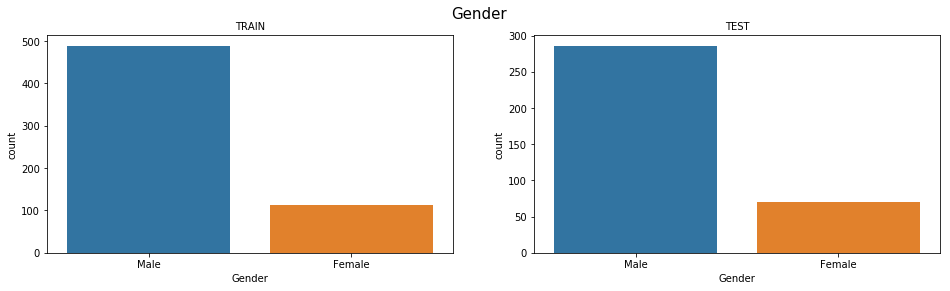

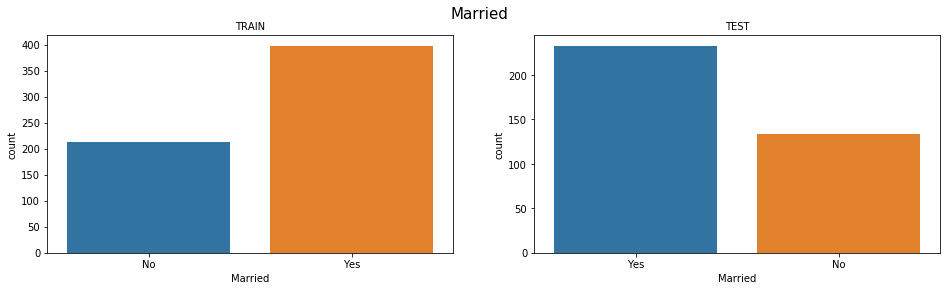

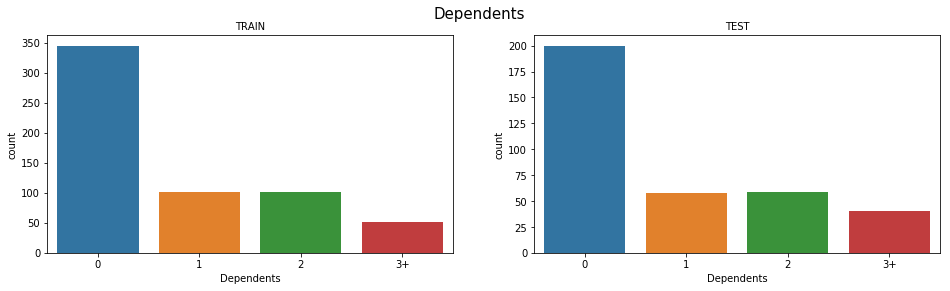

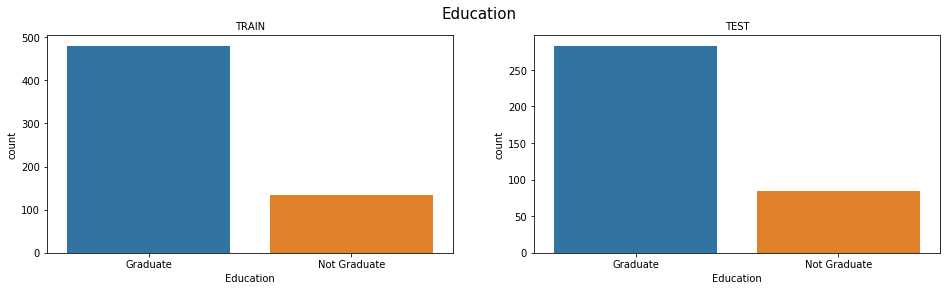

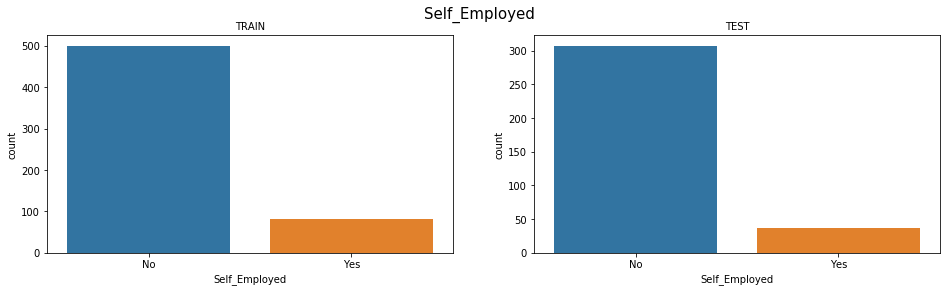

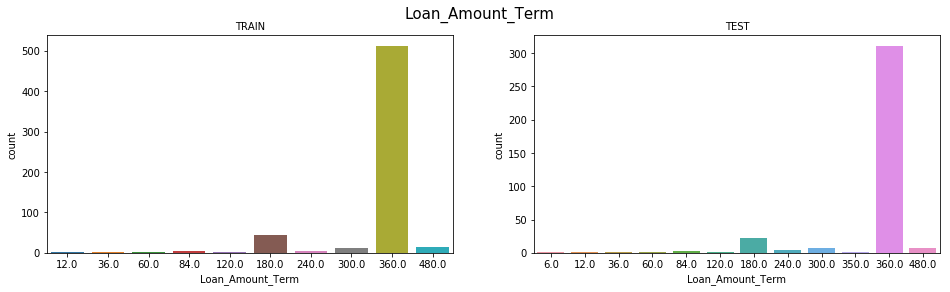

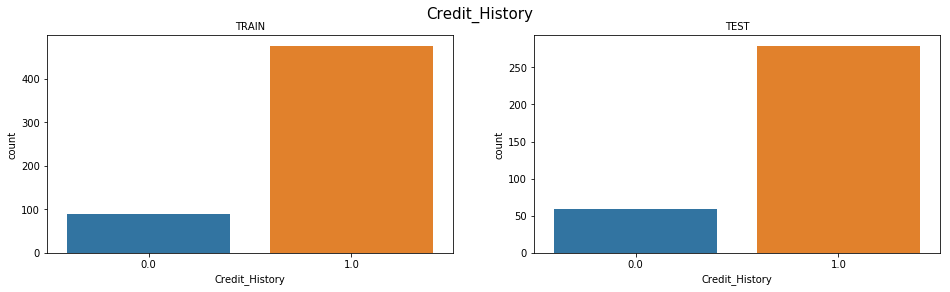

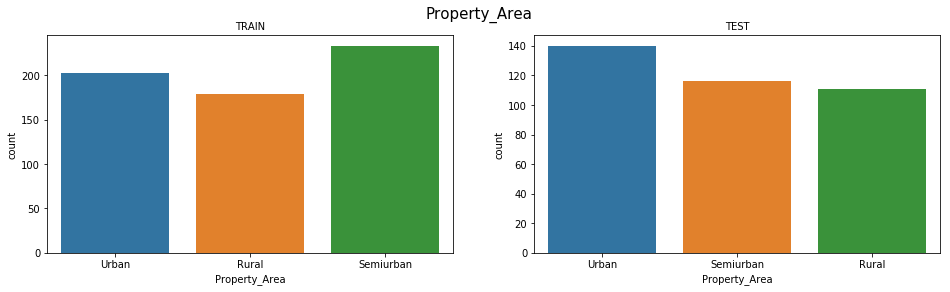

In [66]:
plt.rcParams['figure.figsize'] = (16,4)
for var in cat_var:
    dual_plot(sns.countplot,{'data':train,'x':var},{'data':test,'x':var},tit=var)

## Continous Variable

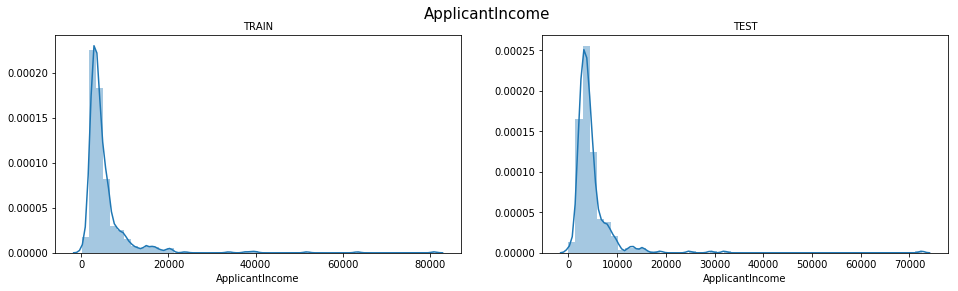

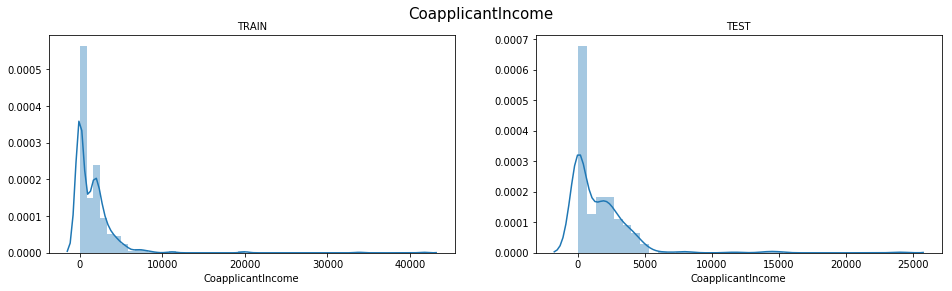

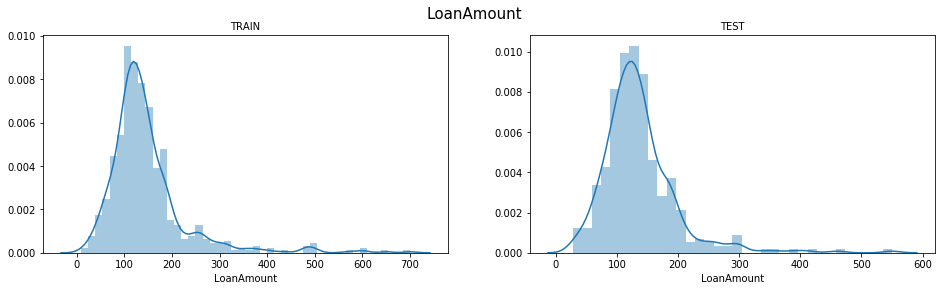

In [67]:
for var in con_var:
    dual_plot(sns.distplot,{'a':train[var].fillna(train[var].mean())},{'a':test[var].fillna(test[var].mean())},tit=var)

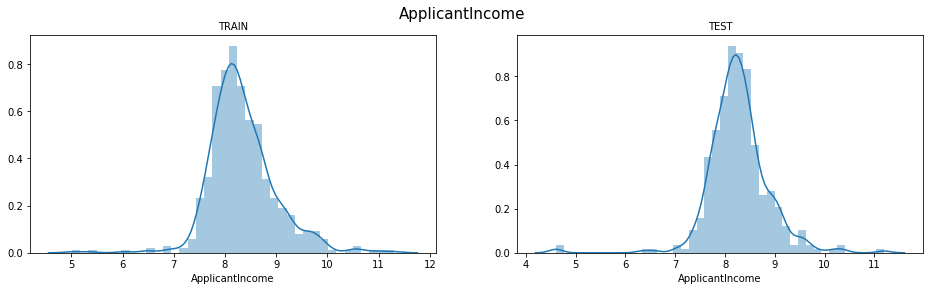

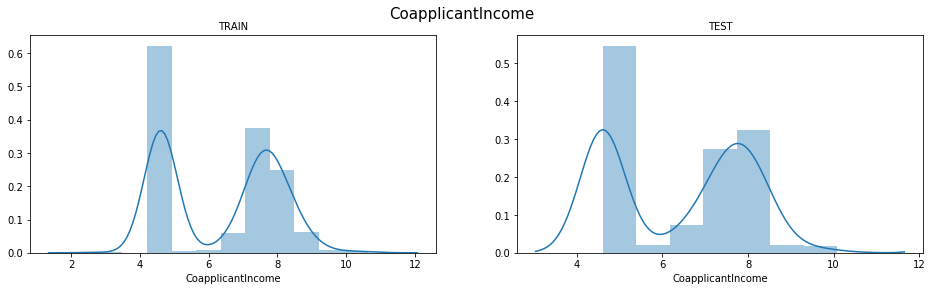

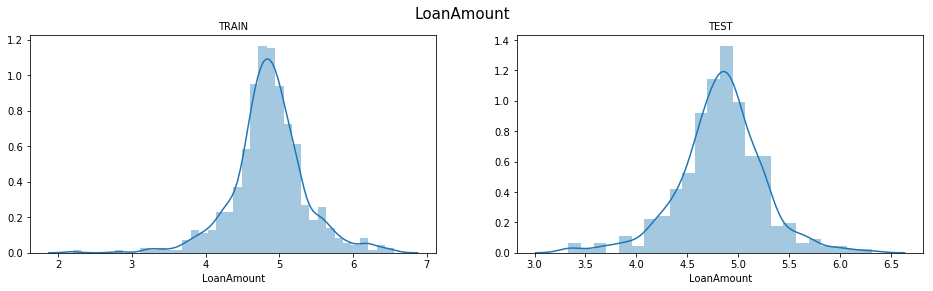

In [68]:
for var in con_var:
    dual_plot(sns.distplot,
              {'a':train[var].fillna(train[var].mean()).apply(lambda x: 10e1 if x==0 else x).apply(np.log)},
              {'a':test[var].fillna(test[var].mean()).apply(lambda x: 10e1 if x==0 else x).apply(np.log)}
              ,tit=var)

## Relationship with target

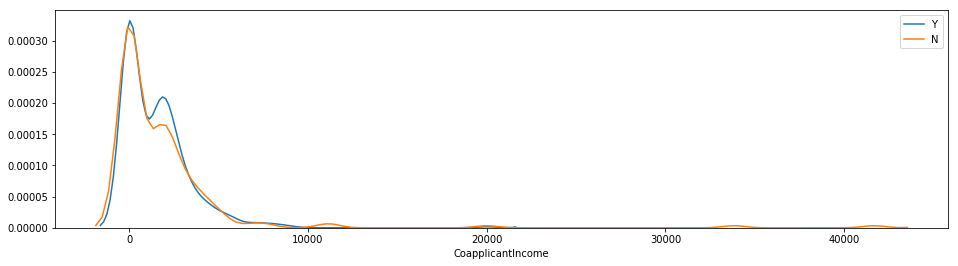

In [69]:
sns.distplot(train.loc[train['Loan_Status']=='Y','CoapplicantIncome']
             .fillna(train.loc[train['Loan_Status']=='Y','CoapplicantIncome'].mean())
#              .apply(np.sqrt)
             , label='Y',hist=False)
sns.distplot(train.loc[train['Loan_Status']=='N','CoapplicantIncome']
             .fillna(train.loc[train['Loan_Status']=='N','CoapplicantIncome'].mean())
#              .apply(np.sqrt)
             , label='N',hist=False)
plt.legend()
plt.show()

## Observation(s)

# Preprocessing

In [70]:
X_train,y_train = (train.drop(columns=['Loan_Status']),train['Loan_Status'])
X_test = test

# Model

## Custom transformer

In [96]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    sklearn transformer, transform DataFrame X to subset of X with selected columns
    """
    def __init__(self, features):
        self.features = features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        assert isinstance(X,pd.DataFrame)
        return X[self.features]

In [97]:
# label encoder for categorical val
class Dummies(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return pd.get_dummies(X,dummy_na=True,columns=X.columns)

## Baseline

In [107]:
base = make_pipeline(
    make_union(
        make_pipeline(
            FeatureSelector(cat_var),
            Dummies()
        ),
        make_pipeline(
            FeatureSelector(con_var),
            Imputer(strategy='mean')
        )
    ),
    LogisticRegression()
)

In [110]:
base.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(memory=None,
     steps=[('featureselector', FeatureSelector(features=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area'])), ('dummies'...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [116]:
cv = cross_validate(base,X_train,y_train,cv = 2)

Acc. score: 0.7996742671009772


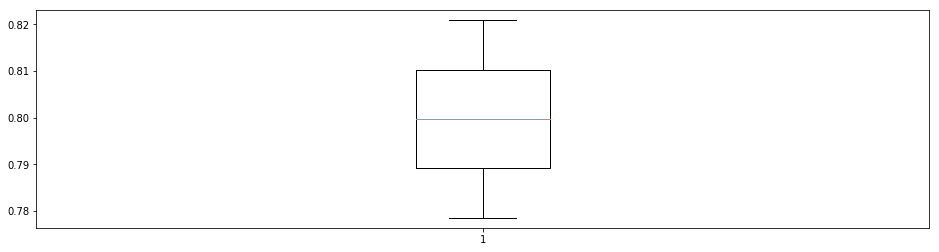

In [117]:
plt.boxplot(cv['test_score'])
print(f"Acc. score: {np.mean(cv['test_score'])}")
plt.show()

In [118]:
pred = base.predict(X_test)

ValueError: X has 40 features per sample; expecting 38

In [ ]:
submission = pd.DataFrame({'Loan_ID':X_test.index,'Loan_Status':pred})

In [ ]:
submission.to_csv(f"submission/submission{str(datetime.datetime.now())}.csv",index=False)